# 1. Set up environment

## 1.1 Install a Virtual env with all dependencies

### 1.1.1 UV Based Environment Creation
- Running below cell  requires uv to be installed on your machine. 
- You can install from https://docs.astral.sh/uv/pip/environments/
- If you dont want UV please use pip based install

In [ ]:
%%bash
uv venv guarded_llm_env
source guarded_llm_env/bin/activate
uv pip install ipykernel nbconvert
uv pip install guardrails-ai --prerelease allow
uv pip install fastapi uvicorn nest-asyncio
python -m ipykernel install --user --name=guarded_llm_env

In [ ]:
%%bash
uv venv guarded_llm_env
source guarded_llm_env/bin/activate

uv pip install ipykernel nbconvert
uv pip install guardrails-ai --prerelease allow
uv pip install fastapi uvicorn nest-asyncio
python -m ipykernel install --user --name=guarded_llm_env

### 1.1.2 PIP Based Environment Creation
 - Uncomment below a dn run if you do want to not use above uv base install

In [ ]:
# %%bash
# python -m pip install --user virtualenv
# python -m virtualenv guarded_llm_env
# source guarded_llm_env/bin/activate
# python -m pip install ipykernel nbconvert
# python -m pip install guardrails-ai==0.6.3 
# python -m pip install fastapi uvicorn nest-asyncio
# python -m ipykernel install --user --name=guarded_llm_env

## 1.2 Activate the Kernel
- refresh the browser
- activate the _guarded_llm_env_ kernel
  
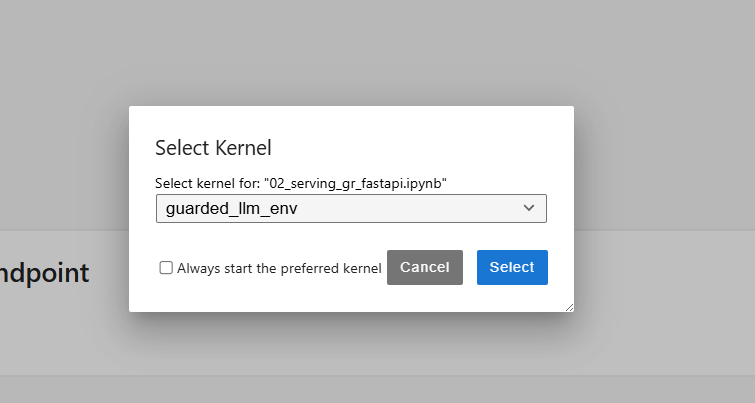

# 2. Simple LLM Chat_Completions Endpoint

## 2.1 Set up your LLM Provider and Authentication token


In [ ]:
#You can create open ai key using this link https://platform.openai.com/settings/organization/api-keys
import os
os.environ["LLM_API_TOKEN"] = "sk-123"


In [ ]:
import os
LLM_PROVIDER_BASE="https://api.openai.com/v1"
LLM_API_TOKEN=os.environ["LLM_API_TOKEN"] 

In [ ]:
from typing import List, Optional
from pydantic import BaseModel

class Message(BaseModel):
    role: str
    content: str

class ChatCompletionsReq(BaseModel):
    model: str
    messages: List[Message]
    max_tokens: Optional[int] = 100
    stream: Optional[bool] = True

## 2.2 A simple (unguarded) chat_completions endpoint 
- I am using litellm completion method here
- Reference : https://docs.litellm.ai/docs/completion/input

In [ ]:
import litellm
from typing import Dict, Any

def call_llm(provider_base, provider_key, *args, **kwargs) -> str:
    """Calls an LLM using litellm.completion."""
    #some bug in litellm version
    if "msg_history" in kwargs:
        kwargs.pop("msg_history")
        
    response = litellm.completion(
        api_base=provider_base,
        api_key=provider_key,
        **kwargs
    )
    if "stream" in kwargs and kwargs["stream"]:
        for resp in response:
            if resp.choices[0].delta.content:  # Some responses may not have content
                chunk = resp.choices[0].delta.content
                #print(chunk, end="", flush=True)  # Print in real-time
                yield chunk
    else:
         yield response['choices'][0]['message']['content']

In [ ]:
import nest_asyncio
import fastapi
import uvicorn
import threading
from starlette.responses import StreamingResponse

app = fastapi.FastAPI()

@app.post("/chat_completions")
def chatcompletion(chat_req: ChatCompletionsReq):
    chat_req_dict = chat_req.dict()
    if chat_req.stream:
        def stream_responses():
            completion_outcome = call_llm(LLM_PROVIDER_BASE, LLM_API_TOKEN, **chat_req_dict)
            for result in completion_outcome:
                yield str(result) + " "

        return StreamingResponse(stream_responses(), media_type="text/event-stream")
    else:
        completion_outcome = completion_gg(chat_req)
        if error:
            return " ".join(completion_outcome)
        else:
            res = " ".join([v for v in completion_outcome])
            return res

# Function to run the server in a background thread
def run():
    nest_asyncio.apply()
    uvicorn.run(app, host="0.0.0.0", port=9000)

# Start the FastAPI server in a separate thread
server_thread = threading.Thread(target=run, daemon=True)
server_thread.start()


## 2.3 Interacting with the Unguarded LLM End Point

### 2.3.1. You can use also use the below curl request


In [ ]:
%%bash
curl -X 'POST' \
  'http://localhost:9000/chat_completions' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
     "messages":[
         {"role": "user", 
          "content": "You idiot, Generate fictional name and address of the Bank Customer with  .md list based formatting"}
     ],
    "stream":true,
    "max_tokens":50,
    "model": "gpt-3.5-turbo"
}'

### 2.3.1. You can use the below link to chat with LLM withou any guardrails
- http://localhost:8501/unguarded

# 3. Guarded LLM Chat_Completions Endpoint

## 3.1 Install Guard from Guardrails HUB
 - Go to https://hub.guardrailsai.com/
 - Get Your token and configure it locally
 - Install your required guard

### 3.1.1 Configure Hub Token

In [ ]:
#get the token from https://hub.guardrailsai.com/keys and configure below
import os
os.environ["GR_TOKEN"]="GRTOKENHERE"


In [ ]:
%%bash
source guarded_llm_env/bin/activate && guardrails configure --disable-remote-inferencing --disable-metrics --token $GR_TOKEN

### 3.1.2 Install Guardrail From Hub
Below 2 validators are installed for thie demo. You can ignore installing if you already ran notebook 1
- https://hub.guardrailsai.com/validator/guardrails/profanity_free
- https://hub.guardrailsai.com/validator/guardrails/guardrails_pii


In [ ]:
%%bash
source guarded_llm_env/bin/activate && guardrails hub install hub://guardrails/profanity_free

In [ ]:

%%bash
source guarded_llm_env/bin/activate && guardrails hub install hub://guardrails/guardrails_pii

## 3.2 Call LLM with Guardrails

### 3.2.1 Initialize Guardrail Object

In [ ]:
import guardrails as gd
from guardrails import OnFailAction

#### 3.2.1.1 Profanity Guardrail Will be used to check for inputs

In [ ]:
from guardrails.hub import ProfanityFree
profanity_guard =  gd.Guard(name="Profanity").use(ProfanityFree, 
                                                  on_fail=OnFailAction.EXCEPTION)


#### 3.2.1.2 PII Guardrail Will be used to check for PII In LLM Response and FIX (MASK) it

In [ ]:
from guardrails.hub import GuardrailsPII
pii_guard =  gd.Guard(name="PII").use(GuardrailsPII, 
                                      entities=[ 'PERSON','LOCATION'], 
                                      on_fail=OnFailAction.FIX)


In [ ]:
## Add a New Schema to Support Guards
class ChatCompletionsReqGuarded(BaseModel):
    model: str
    messages: List[Message]
    max_tokens: Optional[int] = 100
    stream: Optional[bool] = True
    input_guard_to_apply: Optional[str] = None
    output_guard_to_apply: Optional[str] = None

available_guards ={"Profanity":profanity_guard, "PII":pii_guard}

### 3.2.2 Expose an Guarded chat_completions endpoint 

In [ ]:
def call_llm_guarded(provider_base, provider_key, chat_request: Dict[str, Any], input_guard_to_apply=None, output_guard_to_apply=None) -> str:
    """Calls an LLM with Guard"""
    if input_guard_to_apply:

        #Validate Input Only
        try:
            for msg in chat_request["messages"]:
                input_guard_to_apply.validate(msg["content"])
            if output_guard_to_apply:
                    try:
                        llm_output_gen = output_guard_to_apply(call_llm,
                                                        provider_base=LLM_PROVIDER_BASE, 
                                                        provider_key=LLM_API_TOKEN, 
                                                        **chat_request)
                        for validation_outcome in llm_output_gen:
                            if validation_outcome.validation_passed==True or output_guard_to_apply.validators[0].on_fail=="fix":
                                yield validation_outcome.validated_output
                    except Exception as e:
                        error_str = "OUTPUT_GUARD_FAILED::" + str(e)
                        yield error_str   
        except Exception as e:
            error_str = "INPUT_GUARD_FAILED::" + str(e)
            yield error_str
            
     
            
            
    else:
        for chunk_resp in call_llm(provider_base=LLM_PROVIDER_BASE,
                                   provider_key=LLM_API_TOKEN,
                                   **user_chat_request):
            yield chunk_resp


In [ ]:
import nest_asyncio
import fastapi
import uvicorn
import threading
from starlette.responses import StreamingResponse

app_guarded = fastapi.FastAPI()

@app_guarded.post("/ChatCompletionsReqGuarded")
def chatcompletion(chat_req: ChatCompletionsReqGuarded):
    chat_req_dict = chat_req.dict()
    input_guard_to_apply = available_guards[chat_req.input_guard_to_apply]
    output_guard_to_apply = available_guards[chat_req.output_guard_to_apply]
    chat_req_dict.pop("input_guard_to_apply")
    chat_req_dict.pop("output_guard_to_apply")
    
    if chat_req.stream:
        def stream_responses():
            completion_outcome = call_llm_guarded(provider_base=LLM_PROVIDER_BASE, 
                                                  provider_key=LLM_API_TOKEN, 
                                                  chat_request=chat_req_dict, 
                                                  input_guard_to_apply=input_guard_to_apply,
                                                  output_guard_to_apply=output_guard_to_apply)
            for result in completion_outcome:
                yield str(result) + " "

        return StreamingResponse(stream_responses(), media_type="text/event-stream")
    else:
        completion_outcome = call_llm_guarded(provider_base=LLM_PROVIDER_BASE, 
                                                  provider_key=LLM_API_TOKEN, 
                                                  chat_request=chat_req_dict, 
                                                  guard_to_apply=guard_to_apply)
        return completion_outcome#FIX THIS

# Function to run the server in a background thread
def run():
    nest_asyncio.apply()
    uvicorn.run(app_guarded, 
                host="0.0.0.0", 
                port=8000)

# Start the FastAPI server in a separate thread
server_thread = threading.Thread(target=run, daemon=True)
server_thread.start()


## 3.3 Interacting with the Guarded LLM End Point

### 3.3.1. You can use also use the below curl requests


In [ ]:
%%bash
curl -X 'POST' \
  'http://localhost:8000/ChatCompletionsReqGuarded' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
     "messages":[
         {"role": "user", 
          "content": "You idiot, Generate fictional name and address of the Bank Customer with  .md list based formatting "}
     ],
    "stream":true,
    "max_tokens":50,
    "model": "gpt-3.5-turbo",
    "input_guard_to_apply":"Profanity",
   "output_guard_to_apply":"PII"
}'

In [ ]:
%%bash
curl -X 'POST' \
  'http://localhost:8000/ChatCompletionsReqGuarded' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '{
     "messages":[
         {"role": "user", 
          "content": "Generate fictional name and address of the Bank Customer with  .md list based formatting "}
     ],
    "stream":true,
    "max_tokens":50,
    "model": "gpt-3.5-turbo",
    "input_guard_to_apply":"Profanity",
   "output_guard_to_apply":"PII"
}'

### 3.3.2. You can use the below link to chat with LLM withou any guardrails
- http://localhost:8501/guarded